# Uso del CycleGAN para la transformación de imágenes de Angiotomografías

Para este proyecto, se utilizó el Modelo de CycleGAN para poder leer una imagen de un set X y transformarlo, para que parezca que pertenece al set Y. Específicamente, estamos trabajando con sets de imágenes radiológicas con contraste y sin contraste.

>El objetivo de este modelo es entrenar generadores para transformar una imagen desde un dominio $X$ hacia una imagen que se vea como si perteneciera al set $Y$ (y viceversa). 

Algunos ejemplos de las imágenes que tenemos en ambos sets son como las que se ven a continuación:

<img src='notebook_images/IM-0001-0001.jpg' height=30% width=30% align='LEFT' />  

<img src='notebook_images/IM-0002-0001.jpg' height=30% width=30% />

### Uso del Modelo CycleGAN para imágenes no pareadas

El uso de este modelo nos da una manera de que aprenda a mapear de una imagen a otra usando un aprendizaje **no supervisado**. Debido a que las imágenes no son exactamente iguales, permite al modelo entrenar y generar la transformación de imagen a imagen. Los autores de este modelo hicieron sus pruebas convirtiendo caballos a cebras, considerando que las imágenes no se encuentran en una misma posición, o tengan un mismo fondo de imagen, entre otras diferencias. Para leer un poco más, se puede acceder al  [paper original](https://arxiv.org/abs/1703.10593)


### Estructura del CycleGAN

Este modelo trabaja con dos tipos de redes: 2 Discriminadores y 2 Generadores. En este ejemplo, los discriminadores son responsables para clasificar si las imágenes son reales o falsas (tanto para las imágenes en el set $X$ – $Y$). Los generadores son responsables para generar convincentes imágenes falsas de ambos tipos de imágenes. 

Los pasos seguidos en este modelo son los siguientes: 

>1. Se cargarán las imágenes por medio del uso de la librería PyDicom,  que tienes las propiedades para lectura y manipulación de las imágenes de angiotomografía, con extensión DCM y GDCM. Esto generarán datasets que será cargado por medio del Dataloader de Pytorch que generará data para cada set, tanto para entrenamiento y testeo del modelo.
2. Se normalizarán las imágenes en una escala de -1 a 1 para la correcta entrada al modelo.
3. Se crearán las diferentes arquitecturas de acuerdo a las especificaciones del modelo, entre ellos, los discriminadores y generadores.
4. Para el entrenamiento del modelo, se completará con el cálculo de las funciones de costo para los discriminadores y generadores, completando una cierta cantidad de épocas. Se activa el GPU para una mejor ejecución del modelo.
5. Para finalizar el modelo, se debe revisar la veracidad de la ejecución, revisando el gráfico de pérdidas a través del tiempo y revisando las muestras generadas por el modelo.

---

## Carga y visualización de la Data

Para nuestro modelo, se necesitan de las siguientes librerías:


In [1]:
# Carga y transformación de la información
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualización
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### Uso de DataLoaders

La función `get_data_loader_dcm` devuelve Dataloaders para entrenamiento y test que puede cargar data eficientemente y por lotes(batches). 

La data generada para el test de nuestro modelo será estrictamente para alimentar a los generadores, para que luego se puedan visualizar alguna imagen generada de ejemplo.

Esta función también es responsable de que las imágenes tengan el tamaño correcto; en este caso se está usando el formato 256x256x1, las cuales son convertidas a tensores.

In [2]:
def get_data_loader_dcm(image_type, image_dir=Params.path_abs,
                    image_size=128, batch_size=16, num_workers=0):
    
    image_path = ""
    train_path = os.path.join(image_path, 'DCM')
    test_path = os.path.join(image_path, 'DCM')
    
    train_set = DicomDataset(train_path, image_type)
    test_set = DicomDataset(test_path, 'test_{}'.format(image_type))  
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, test_loader

In [4]:
dataloader_X, test_dataloader_X = get_data_loader_dcm(image_type='0')
dataloader_Y, test_dataloader_Y = get_data_loader_dcm(image_type='1')

type(dataloader_X)

## Presentación preliminar de Imágenes

La función `imshow` ayuda a cambiar algunas imágenes y las convierte en imágenes tipo NumPy images para que puedan ser presentados por `plt`. Esto presenta un grupo de imágenes del set $X$.

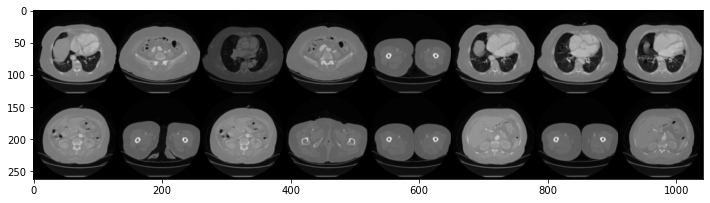

In [5]:
# Función imshow del archivo helpers.py
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# toma algunas imágenes de X
dataiter = iter(dataloader_X)
# El símbolo "_" es un marcado de posición para indicar sin etiquetas de texto
images, _ = dataiter.next()

# Muestra las imágenes
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

En el siguiente cuadro, se visualizan un grupo de imágenes del set $Y$.

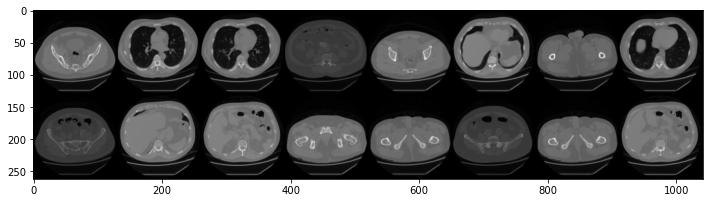

In [6]:
# toma algunas imágenes de Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# Muestra las imágenes
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-procesamiento: escalando desde -1 a 1

Para que el modelo pueda funcionar de acuerdo a lo necesitado, se debe escalar los valores de los pixeles de las imágenes en nuestros datasets, con un rango de -1 a 1. Para nuestro proyecto y debido a que las imágenes de Angiotomografía son a escala de grises, se encuentran con un rango de -1000 a 1000.

In [7]:
# Rango Actual
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(0.9294)


In [8]:
# Función scale del archivo helpers.py
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # Realiza el escalamiento a la variable feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [9]:
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(0.8588)


---

## Discriminadores

Dentro del modelo del CycleGAN, se definieron 2 discriminadores, X y Y. Esto está compuesto de varias redes convolucionales que verán una imagen e intentarán clasificarlas como reales o falsas. En este caso, las reales tendrán un aproximamiento a 1 y las falsas, a 0. Los discriminadores tienen la siguiente estructura: 

<img src='notebook_images/discriminator_layers.png' width=80% />

Esta red ve una imagen con los parámetros 256x256x1, la comprime en una representación de una característica mientras va pasando por 3 redes convolucionales, llega a una serie de bloques residuales (en este caso, 6) y luego pasa por redes convolucionales transpuestas (llamadas capas de-convolucionales) que utiliza esta representación para recrear nuevamente una nueva imagen. 

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# Función conv del archivo helpers.py
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Crea una capa convolucional con batch normalization opcional
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define todas las capas convolucionales
        # Para este modelo, debe aceptar una imagen en escala de grises como entrada y como salida un único valor

        # Capas Convolucionales, incrementando en profundidad
        # La primera capa no tiene la capa de batchnorm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Capa de clasificación
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # Función ReLu aplicada para todas las capas convolucionales excepto la última capa
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        # Última capa, capa de clasificación
        out = self.conv5(out)
        return out

## Generadores

Los generadores creados (`G_XtoY` y `G_YtoX`), fueron configurados en base a un modelo **encoder**, un grupo de redes convolucionales que son responsables de cambiar una imagen a una representación más pequeña de la misma. Además, cuenta con un modelo **decoder**, una red convolucional transpuesta, que es responsable de transformar dicha representación en una imagen transformada. Estos generadores, uno para `XtoY` y otro para `YtoX`, tiene la siguiente arquitectura:

<img src='notebook_images/cyclegan_generator_ex.png' width=90% />

Esta red ve una imagen con los parámetros 256x256x1, la comprime en una representación de una característica mientras va pasando por 3 redes convolucionales, llega a una serie de bloques residuales (en este caso, 6) y luego pasa por redes convolucionales transpuestas (llamadas capas de-convolucionales) que utiliza esta representación para recrear nuevamente una nueva imagen.

---
### Clase de Bloque Residual

Para definir los generadores, se define una clase de Bloque Residual que ayudará a conectar las partes de los modelos encoder y decoder de los generadores.

<img src='notebook_images/resnet_50.png' width=90%/>

Los bloques ResNet se basan en conectar la salida de una capa con la entrada de una capa anterior. 

La motivación de esta estructura es la siguiente: las redes neuronales muy profundas pueden ser difíciles de entrenar. 

Es más probable que las redes más profundas tengan gradientes que se desvanecen o explotan y, por lo tanto, tienen problemas para alcanzar la convergencia; la normalización por lotes ayuda un poco con esto. Sin embargo, durante el entrenamiento, a menudo vemos que las redes profundas responden con una especie de degradación del entrenamiento. Esencialmente, la precisión del entrenamiento está mejorando y se satura en algunas paradas durante el entrenamiento. En el peor de los casos, los modelos profundos verían cómo su precisión de entrenamiento empeora con el tiempo.

<img src='notebook_images/resnet_block.png' width=40%/>


In [12]:
# Clase de bloques residuales
class ResidualBlock(nn.Module):
    """ Aquí se define un bloque residual
        Esto añade una entrada X a una capa convolucional (aplicado a X) con el mismo tamaño de entrada y salida.
        Estos bloques permiten al modelo aprender una transformación efectiva desde un dominio a otro.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # la variable conv_dim define el número de entradas
        # se definen 2 capas convolucionales + batch normalization, que va a actuar como nuestra función residual, F(x)
        # Las capas deben tener la misma forma de entrada que de salida.
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
    
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
    

### Transposición de la función auxiliar convolucional

Para definir los generadores, se usa la función conv anterior, la clase Bloque Residual y la función auxiliar de deconv a continuación, que crea una capa convolucional de transposición + una capa de norma por lotes opcional.

In [13]:
# Función deconv del archivo helpers.py
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Esta función crea una capa convolucional transpuesta, con un batch normalization opcional. 
    """
    layers = []
    # agrega una capa convolucional transpuesta
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # capa batch norm opcional
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Definición de la arquitectura del Generador

* La función `__init__` tiene 3 capas específicas convolucionales **encoder**, una serie de bloques residuales  (el número dado en la variable `n_res_blocks`), y luego 3 capas transpuestas convolucionales **decoder**.
* La función `forward` define el comportamiento a futuro de los generadores. Hace la llamada a la última capa que tiene una función de activación `tanh`.

In [14]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Definir la parte del encodificador para el generador
        
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Definir parte resnet del generador
        # Bloques residuales
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))

        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Definir la parte encodificadora del generador
        # 2 capas convolucionales transpuestas y un tercero que se parece mucho a la capa convolucional inicial
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # no se aplica batch norm en la última capa
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Dada una imagen x, devuelve una imagen transformada"""

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))

        out = F.tanh(self.deconv3(out))

        return out

---
## Creación del Modelo completo

A partir de este momento, se pueden definir los discriminadores y generadores necesarios para crear todo el modelo CycleGAN. 


In [15]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Construye los generadores y discriminadores"""

    # Inicializa Generadores
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Inicializa Discriminadores
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # se mueven los modelos a la GPU, de estar disponibles
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [16]:
# Llamada de la función crear modelo desde el checkpoint creado
# NO UTILIZAR SI NO EXISTEN ARCHIVOS PKL GENERADOS DE UN MODELO ANTERIOR
G_XtoY, G_YtoX, D_X, D_Y = create_model()

print(G_XtoY.state_dict()['conv1.0.weight'][0])

Models moved to GPU.


In [ ]:
# Llamada de la función cargar modelo desde el checkpoint creado
# NO UTILIZAR SI NO EXISTEN ARCHIVOS PKL GENERADOS DE UN MODELO ANTERIOR
def load_model(G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan'):
    try:

        checkpoint_dir = os.path.join(Params.path_abs, checkpoint_dir, 'G_XtoY.pkl')
        if os.path.exists(checkpoint_dir):
            state_dict = torch.load(checkpoint_dir)
            G_XtoY.load_state_dict(state_dict)

        checkpoint_dir = os.path.join(Params.path_abs, checkpoint_dir, 'G_YtoX.pkl')
        if os.path.exists(checkpoint_dir):
            state_dict = torch.load(checkpoint_dir)
            G_XtoY.load_state_dict(state_dict)

        checkpoint_dir = os.path.join(Params.path_abs, checkpoint_dir, 'D_X.pkl')
        if os.path.exists(checkpoint_dir):
            state_dict = torch.load(checkpoint_dir)
            G_XtoY.load_state_dict(state_dict)

        checkpoint_dir = os.path.join(Params.path_abs, checkpoint_dir, 'D_Y.pkl')
        if os.path.exists(checkpoint_dir):
            state_dict = torch.load(checkpoint_dir)
            G_XtoY.load_state_dict(state_dict)

        return G_XtoY, G_YtoX, D_X, D_Y
    except Exception as ex:
        print(ex)
        return ex

In [ ]:
# llamadas al modelo cuando es la corrida por primera vez
# POR PRIMERA VEZ LA CORRIDA DEL MODELO
G_XtoY, G_YtoX, D_X, D_Y = create_model()

## Control de Calidad a la creación del modelo

La función `create_model` debe presentar las redes de los generadores y de los discriminadores. Esta función imprime la arquitectura del modelo permite revisar si los parámetros son los esperados. 

In [17]:
# función para imprimir la arquitectura del modelo
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# imprimir todos los modelos
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

---
### Definición de las funciones de costo

Para calcular las pérdidas del discriminador y del generador durante el entrenamiento, se definen algunas funciones de pérdida a continuación:
1. `real_mse_loss` analiza la salida de un discriminador y devuelve el error en función de lo cerca que está esa salida de ser clasificada como real. La función usa el método del error cuadrático medio.
2. `fake_mse_loss` analiza la salida de un discriminador y devuelve el error en función de lo cerca que está esa salida de ser clasificada como falsa. La función usa el método del error cuadrático medio.
3. `cycle_consistency_loss` analiza un conjunto de imágenes reales, un conjunto de imágenes reconstruidas/generadas, y devuelve el error absoluto medio entre ellas. Tiene un parámetro `lambda_weight` que pondera el error absoluto medio en un lote.

In [18]:
def real_mse_loss(D_out):
    # qué tan cerca es la salida producida de ser "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # qué tan cerca es la salida producida de ser "real"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # se calcula la pérdida de construcción como un valor absoluto que diferencia entre lo real y las imágenes reconstruídas
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # retorna la pérdida en pesos
    return lambda_weight*reconstr_loss    


### Define the Optimizers

A continuación, definamos cómo este modelo actualizará sus pesos. Este utiliza optimizadores [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) para el discriminador y el generador. 

In [19]:
import torch.optim as optim

# hiperparámetros para el optimizador Adam
lr=0.0001
beta1=0.5
beta2=0.999 # valor por defecto

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters()) # Guardar parámetros del generador

# Crear optimizadores para los generadores y discriminadores
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Entrenando el Modelo CycleGAN

Cuando CycleGAN entrena y ve un lote de imágenes reales del conjunto $X$ y $Y$, entrena realizando los siguientes pasos:

**Entrenando a los Discriminadores**
1. Calcula la pérdida del discriminador $D_X$ en imágenes reales
2. Genera imágenes falsas que se parezcan al dominio $X$ basándose en imágenes reales del dominio $Y$
3. Calcula la pérdida falsa de $D_X$
4. Calcula la pérdida total y realice la retropropagación y la optimización $D_X$
5. Se repiten los pasos 1-4 solo con $D_Y$


**Entrenando a los Generadores**
1. Generar imágenes falsas que se parezcan al dominio $X$ basándose en imágenes reales del dominio $Y$
2. Calcular la pérdida del generador en función de cómo responde $D_X$ a $X$ falsos
3. Generar imágenes *reconstruidas* $\hat{Y}$ basadas en las imágenes $X$ falsas generadas en el paso 1
4. Calcular la pérdida de consistencia del ciclo comparando las reconstrucciones con imágenes reales de $Y$
5. Repetir los pasos 1-4 solo intercambiando dominios
6. Sumar todas las pérdidas del generador y de reconstrucción y realice backpropagation + optimización


In [20]:
from helpers import save_samples, checkpoint

In [21]:
#Entrenamiento de la Red

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # Mantiene los registros de las pérdidas a traves del tiempo
    losses = []
    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Se obtiene algo de la data generada de los dominios X y Y para ejemplos. 
    # Estas imágenes se mantendrán constantes durante el entrenamiento, 
    # que nos permitirán inspeccionar el desempeño del modelo.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) 
    fixed_Y = scale(fixed_Y)

    # lotes por épocas
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Resetea el iterador por cada épocas
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X)

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # mover imágenes a la GPU si se encuentra habilitado (caso contrario queda en CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #        ENTRENAR LOS DISCRIMINADORES
        # ============================================ 

        ##   Primero: D_X, componentes para la pérdida real y falsa   ##

        # Entrenamiento con las imágenes reales 
        d_x_optimizer.zero_grad()

        # 1. Procesar las pérdidas del discriminador en imágenes reales
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Entrenamiento con las imágenes falsas
        
        # 2. Se generar las imágenes falsas que son parecidas al dominio X basados en imágenes reales en el dominio Y 
        fake_X = G_YtoX(images_Y)

        # 3. Se procesan las pérdidas falsas por D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        

        # 4. Procesar la pérdida total y el backprop performance 
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Segundo: D_Y, componentes reales y falsos   ##
        
        # Entrenamiento con las imágenes reales
        d_y_optimizer.zero_grad()
        
        # 1. Procesar las pérdidas del discriminador en imágenes reales
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Entrenamiento con las imágenes falsas

        # 2. Se generan imágenes falsas que son parecidas al dominio Y basados en imágenes reales en el dominio X
        fake_Y = G_XtoY(images_X)

        # 3. Procesar las pérdidas falsas por D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Procesar la pérdida total y el backprop performance 
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            ENTRENAR LOS GENERADORES
        # =========================================

        ##   Primero: Generar una cantidad de imágenes falsas del dominio X e imágenes reconstruídas del dominio Y    ##
        g_optimizer.zero_grad()

        # 1. Generar imágenes falsas que se parezcan a las que están en el dominio X, basados en imágenes reales del dominio Y 
        fake_X = G_YtoX(images_Y)

        # 2. Procesar la pérdida del generador basado en el dominio X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Crear la reconstrucción de imágenes Y 
        # 4. Procesar el proceso de pérdida del cycle consistency (la reconstrucción de la pérdida)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


        ##    Segundo: Generar imágenes falsas del dominio Y e imágenes reconstruídas del dominio X    ##

        # 1. Generar imágenes falsas que se parezcan a las que están en el dominio Y, basados en imágenes reales del dominio X 
        fake_Y = G_XtoY(images_X)

        # 2. Procesar la pérdida del generador basado en el dominio Y 
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Creación de un X reconstruido 
        # 4. Procesar el proceso de pérdida del cycle consistency (la reconstrucción de la pérdida)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # 5. Añadir todas las pérdidas de los generadores y de las imágenes reconstruídas, ejecutando el backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()


        # Imprimir la información del log 
        if epoch % print_every == 0:
            # Agrega las pérdidas reales y falsas del discriminador y del generador
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Graba las muestras generadas 
        if epoch % sample_every == 0:
            G_YtoX.eval() 
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()


        checkpoint_every=1000
         # Grabar los parámetros del modelo
        if epoch % checkpoint_every == 0:
             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [22]:
n_epochs = 4000 

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 1000] | d_X_loss: 162.0139 | d_Y_loss: 129.3592 | g_total_loss: 119.9026
Epoch [   20/ 1000] | d_X_loss: 5.6554 | d_Y_loss: 7.2856 | g_total_loss: 36.5412
Epoch [   30/ 1000] | d_X_loss: 2.4990 | d_Y_loss: 3.7282 | g_total_loss: 34.7570
Epoch [   40/ 1000] | d_X_loss: 1.3342 | d_Y_loss: 2.1939 | g_total_loss: 33.6094
Epoch [   50/ 1000] | d_X_loss: 0.9309 | d_Y_loss: 0.9905 | g_total_loss: 33.4281
Epoch [   60/ 1000] | d_X_loss: 0.5278 | d_Y_loss: 0.8125 | g_total_loss: 34.0439
Epoch [   70/ 1000] | d_X_loss: 0.4433 | d_Y_loss: 0.6420 | g_total_loss: 33.9507
Epoch [   80/ 1000] | d_X_loss: 0.3814 | d_Y_loss: 0.6695 | g_total_loss: 33.4543
Epoch [   90/ 1000] | d_X_loss: 0.3735 | d_Y_loss: 0.3968 | g_total_loss: 34.0501


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  100/ 1000] | d_X_loss: 0.2854 | d_Y_loss: 0.2838 | g_total_loss: 33.5180


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000100-X-Y.png
Saved samples_cyclegan\sample-000100-Y-X.png
Epoch [  110/ 1000] | d_X_loss: 0.2695 | d_Y_loss: 0.3236 | g_total_loss: 33.6121
Epoch [  120/ 1000] | d_X_loss: 0.1810 | d_Y_loss: 0.2960 | g_total_loss: 33.8922
Epoch [  130/ 1000] | d_X_loss: 0.2469 | d_Y_loss: 0.2937 | g_total_loss: 33.4073
Epoch [  140/ 1000] | d_X_loss: 0.1827 | d_Y_loss: 0.1892 | g_total_loss: 34.2215
Epoch [  150/ 1000] | d_X_loss: 0.1527 | d_Y_loss: 0.1446 | g_total_loss: 33.9140
Epoch [  160/ 1000] | d_X_loss: 0.1438 | d_Y_loss: 0.2503 | g_total_loss: 33.2735
Epoch [  170/ 1000] | d_X_loss: 0.0942 | d_Y_loss: 0.1559 | g_total_loss: 33.8305
Epoch [  180/ 1000] | d_X_loss: 0.1132 | d_Y_loss: 0.1740 | g_total_loss: 33.0515
Epoch [  190/ 1000] | d_X_loss: 0.1266 | d_Y_loss: 0.1099 | g_total_loss: 33.7187


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  200/ 1000] | d_X_loss: 0.1019 | d_Y_loss: 0.2116 | g_total_loss: 33.4952


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000200-X-Y.png
Saved samples_cyclegan\sample-000200-Y-X.png
Epoch [  210/ 1000] | d_X_loss: 0.0810 | d_Y_loss: 0.1535 | g_total_loss: 33.7584
Epoch [  220/ 1000] | d_X_loss: 0.0622 | d_Y_loss: 0.2657 | g_total_loss: 33.0812
Epoch [  230/ 1000] | d_X_loss: 0.0910 | d_Y_loss: 0.2914 | g_total_loss: 33.7955
Epoch [  240/ 1000] | d_X_loss: 0.1058 | d_Y_loss: 0.0676 | g_total_loss: 33.9706
Epoch [  250/ 1000] | d_X_loss: 0.1237 | d_Y_loss: 0.1342 | g_total_loss: 33.4473
Epoch [  260/ 1000] | d_X_loss: 0.0664 | d_Y_loss: 0.0605 | g_total_loss: 33.5471
Epoch [  270/ 1000] | d_X_loss: 0.0651 | d_Y_loss: 0.0939 | g_total_loss: 33.4825
Epoch [  280/ 1000] | d_X_loss: 0.0796 | d_Y_loss: 0.0982 | g_total_loss: 34.1505
Epoch [  290/ 1000] | d_X_loss: 0.1038 | d_Y_loss: 0.1615 | g_total_loss: 34.6651


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  300/ 1000] | d_X_loss: 0.0642 | d_Y_loss: 0.0608 | g_total_loss: 33.7466


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000300-X-Y.png
Saved samples_cyclegan\sample-000300-Y-X.png
Epoch [  310/ 1000] | d_X_loss: 0.1119 | d_Y_loss: 0.1098 | g_total_loss: 34.1722
Epoch [  320/ 1000] | d_X_loss: 0.0520 | d_Y_loss: 0.0769 | g_total_loss: 33.5558
Epoch [  330/ 1000] | d_X_loss: 0.0721 | d_Y_loss: 0.1020 | g_total_loss: 34.0380
Epoch [  340/ 1000] | d_X_loss: 0.0460 | d_Y_loss: 0.1082 | g_total_loss: 33.8420
Epoch [  350/ 1000] | d_X_loss: 0.0423 | d_Y_loss: 0.0861 | g_total_loss: 33.8820
Epoch [  360/ 1000] | d_X_loss: 0.0352 | d_Y_loss: 0.0591 | g_total_loss: 33.7097
Epoch [  370/ 1000] | d_X_loss: 0.0444 | d_Y_loss: 0.0468 | g_total_loss: 33.9810
Epoch [  380/ 1000] | d_X_loss: 0.0302 | d_Y_loss: 0.0533 | g_total_loss: 33.7957
Epoch [  390/ 1000] | d_X_loss: 0.0495 | d_Y_loss: 0.0892 | g_total_loss: 33.9237


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  400/ 1000] | d_X_loss: 0.0449 | d_Y_loss: 0.0573 | g_total_loss: 34.1706


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000400-X-Y.png
Saved samples_cyclegan\sample-000400-Y-X.png
Epoch [  410/ 1000] | d_X_loss: 0.0385 | d_Y_loss: 0.0662 | g_total_loss: 33.6123
Epoch [  420/ 1000] | d_X_loss: 0.0284 | d_Y_loss: 0.0525 | g_total_loss: 33.5879
Epoch [  430/ 1000] | d_X_loss: 0.0371 | d_Y_loss: 0.0626 | g_total_loss: 33.5486
Epoch [  440/ 1000] | d_X_loss: 0.0287 | d_Y_loss: 0.0790 | g_total_loss: 33.6720
Epoch [  450/ 1000] | d_X_loss: 0.0556 | d_Y_loss: 0.0318 | g_total_loss: 33.8953
Epoch [  460/ 1000] | d_X_loss: 0.0288 | d_Y_loss: 0.0619 | g_total_loss: 33.7367
Epoch [  470/ 1000] | d_X_loss: 0.0288 | d_Y_loss: 0.0300 | g_total_loss: 33.7582
Epoch [  480/ 1000] | d_X_loss: 0.0252 | d_Y_loss: 0.0715 | g_total_loss: 34.1566
Epoch [  490/ 1000] | d_X_loss: 0.0459 | d_Y_loss: 0.0413 | g_total_loss: 33.8320


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  500/ 1000] | d_X_loss: 0.0499 | d_Y_loss: 0.0460 | g_total_loss: 33.6239


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000500-X-Y.png
Saved samples_cyclegan\sample-000500-Y-X.png
Epoch [  510/ 1000] | d_X_loss: 0.0220 | d_Y_loss: 0.0404 | g_total_loss: 33.5569
Epoch [  520/ 1000] | d_X_loss: 0.0503 | d_Y_loss: 0.0367 | g_total_loss: 34.7528
Epoch [  530/ 1000] | d_X_loss: 0.0365 | d_Y_loss: 0.0470 | g_total_loss: 33.8095
Epoch [  540/ 1000] | d_X_loss: 0.0337 | d_Y_loss: 0.0310 | g_total_loss: 33.3124
Epoch [  550/ 1000] | d_X_loss: 0.0897 | d_Y_loss: 0.0374 | g_total_loss: 34.1231
Epoch [  560/ 1000] | d_X_loss: 0.0321 | d_Y_loss: 0.0320 | g_total_loss: 33.6796
Epoch [  570/ 1000] | d_X_loss: 0.0280 | d_Y_loss: 0.0291 | g_total_loss: 34.1079
Epoch [  580/ 1000] | d_X_loss: 0.0263 | d_Y_loss: 0.0361 | g_total_loss: 33.9365
Epoch [  590/ 1000] | d_X_loss: 0.0970 | d_Y_loss: 0.0524 | g_total_loss: 33.7663


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  600/ 1000] | d_X_loss: 0.0380 | d_Y_loss: 0.0293 | g_total_loss: 33.9181


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000600-X-Y.png
Saved samples_cyclegan\sample-000600-Y-X.png
Epoch [  610/ 1000] | d_X_loss: 0.1308 | d_Y_loss: 0.0229 | g_total_loss: 34.6119
Epoch [  620/ 1000] | d_X_loss: 0.1496 | d_Y_loss: 0.1001 | g_total_loss: 34.4221
Epoch [  630/ 1000] | d_X_loss: 0.0231 | d_Y_loss: 0.0284 | g_total_loss: 33.6911
Epoch [  640/ 1000] | d_X_loss: 0.0860 | d_Y_loss: 0.0368 | g_total_loss: 33.8474
Epoch [  650/ 1000] | d_X_loss: 0.0389 | d_Y_loss: 0.1109 | g_total_loss: 33.0172
Epoch [  660/ 1000] | d_X_loss: 0.0558 | d_Y_loss: 0.0419 | g_total_loss: 34.4845
Epoch [  670/ 1000] | d_X_loss: 0.6575 | d_Y_loss: 0.0532 | g_total_loss: 33.3995
Epoch [  680/ 1000] | d_X_loss: 2.1723 | d_Y_loss: 0.1160 | g_total_loss: 32.4197
Epoch [  690/ 1000] | d_X_loss: 0.0159 | d_Y_loss: 0.0233 | g_total_loss: 33.9496


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  700/ 1000] | d_X_loss: 0.1650 | d_Y_loss: 0.0477 | g_total_loss: 33.5387


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000700-X-Y.png
Saved samples_cyclegan\sample-000700-Y-X.png
Epoch [  710/ 1000] | d_X_loss: 0.0258 | d_Y_loss: 0.0169 | g_total_loss: 33.5763
Epoch [  720/ 1000] | d_X_loss: 0.0178 | d_Y_loss: 0.0171 | g_total_loss: 33.8336
Epoch [  730/ 1000] | d_X_loss: 0.1163 | d_Y_loss: 0.0144 | g_total_loss: 34.1601
Epoch [  740/ 1000] | d_X_loss: 0.9184 | d_Y_loss: 0.0381 | g_total_loss: 35.8277
Epoch [  750/ 1000] | d_X_loss: 0.3490 | d_Y_loss: 0.0508 | g_total_loss: 33.9911
Epoch [  760/ 1000] | d_X_loss: 0.1760 | d_Y_loss: 0.1155 | g_total_loss: 34.5482
Epoch [  770/ 1000] | d_X_loss: 2.0947 | d_Y_loss: 0.0199 | g_total_loss: 36.5964
Epoch [  780/ 1000] | d_X_loss: 0.5291 | d_Y_loss: 0.1246 | g_total_loss: 34.9324
Epoch [  790/ 1000] | d_X_loss: 0.0501 | d_Y_loss: 0.0253 | g_total_loss: 34.1400


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  800/ 1000] | d_X_loss: 0.1796 | d_Y_loss: 0.0285 | g_total_loss: 33.9922


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000800-X-Y.png
Saved samples_cyclegan\sample-000800-Y-X.png
Epoch [  810/ 1000] | d_X_loss: 0.4418 | d_Y_loss: 0.1096 | g_total_loss: 34.4909
Epoch [  820/ 1000] | d_X_loss: 0.1637 | d_Y_loss: 0.0265 | g_total_loss: 34.5479
Epoch [  830/ 1000] | d_X_loss: 0.3028 | d_Y_loss: 0.0514 | g_total_loss: 34.3327
Epoch [  840/ 1000] | d_X_loss: 0.1518 | d_Y_loss: 0.1121 | g_total_loss: 34.8257
Epoch [  850/ 1000] | d_X_loss: 0.0725 | d_Y_loss: 0.1898 | g_total_loss: 33.6562
Epoch [  860/ 1000] | d_X_loss: 0.7770 | d_Y_loss: 0.0394 | g_total_loss: 32.9299
Epoch [  870/ 1000] | d_X_loss: 0.5550 | d_Y_loss: 0.0764 | g_total_loss: 33.1403
Epoch [  880/ 1000] | d_X_loss: 2.5758 | d_Y_loss: 0.0320 | g_total_loss: 33.1836
Epoch [  890/ 1000] | d_X_loss: 1.3547 | d_Y_loss: 0.0212 | g_total_loss: 32.9768


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  900/ 1000] | d_X_loss: 0.0693 | d_Y_loss: 0.0685 | g_total_loss: 34.8704


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000900-X-Y.png
Saved samples_cyclegan\sample-000900-Y-X.png
Epoch [  910/ 1000] | d_X_loss: 0.0118 | d_Y_loss: 0.0732 | g_total_loss: 33.3365
Epoch [  920/ 1000] | d_X_loss: 0.0386 | d_Y_loss: 0.0606 | g_total_loss: 33.4175
Epoch [  930/ 1000] | d_X_loss: 0.0656 | d_Y_loss: 0.2773 | g_total_loss: 32.8435
Epoch [  940/ 1000] | d_X_loss: 0.2162 | d_Y_loss: 0.9929 | g_total_loss: 32.2222
Epoch [  950/ 1000] | d_X_loss: 0.0498 | d_Y_loss: 0.5267 | g_total_loss: 33.1213
Epoch [  960/ 1000] | d_X_loss: 0.2867 | d_Y_loss: 0.2815 | g_total_loss: 34.0540
Epoch [  970/ 1000] | d_X_loss: 1.5568 | d_Y_loss: 0.2935 | g_total_loss: 34.1920
Epoch [  980/ 1000] | d_X_loss: 0.6314 | d_Y_loss: 2.8348 | g_total_loss: 36.2271
Epoch [  990/ 1000] | d_X_loss: 0.1221 | d_Y_loss: 0.0173 | g_total_loss: 33.1339


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1000/ 1000] | d_X_loss: 0.4869 | d_Y_loss: 0.0162 | g_total_loss: 35.1552


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001000-X-Y.png
Saved samples_cyclegan\sample-001000-Y-X.png


#### Pérdida de los discriminadores

Cuando se visualizan las pérdidas del generador y del discriminador, se debería ver que siempre hay alguna pérdida del discriminador; hay que recordar que estamos tratando de diseñar un modelo que pueda generar buenas imágenes "falsas". Por lo tanto, el discriminador ideal no podrá diferenciar entre imágenes reales y falsas y, como tal, siempre tendrá alguna pérdida. También se debería ver que $D_X$ y $D_Y$ están aproximadamente en los mismos niveles de pérdida; si no lo son, esto indica que el entrenamiento está favoreciendo un tipo de discriminador.

#### Pérdida del Generador

La pérdida del generador debe comenzar significativamente más alta que las pérdidas del discriminador porque tiene en cuenta la pérdida de ambos generadores *y* los errores de reconstrucción ponderados. Se debería observar que esta pérdida disminuye mucho al comienzo del entrenamiento porque las imágenes iniciales generadas a menudo están lejos de ser buenas falsificaciones. Después de algún tiempo puede estabilizarse; esto es normal ya que tanto el generador como el discriminador mejoran a medida que se entrenan.

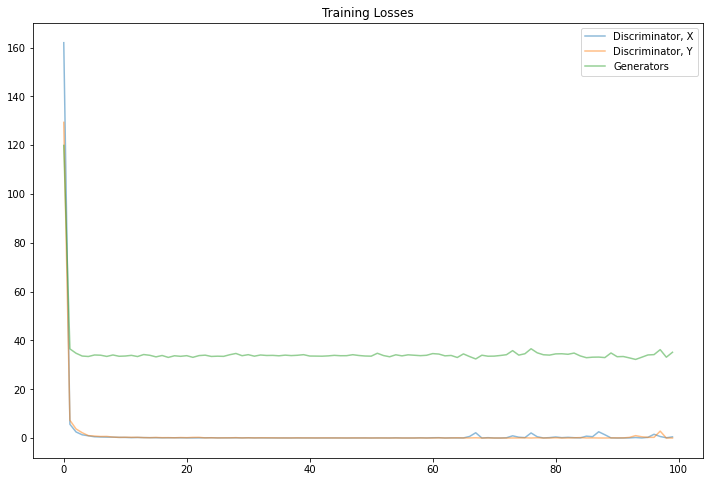

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Resultados del Modelo


In [24]:
import matplotlib.image as mpimg

# Código de visualización del modelo
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # Las muestras son llamadas por iteración
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


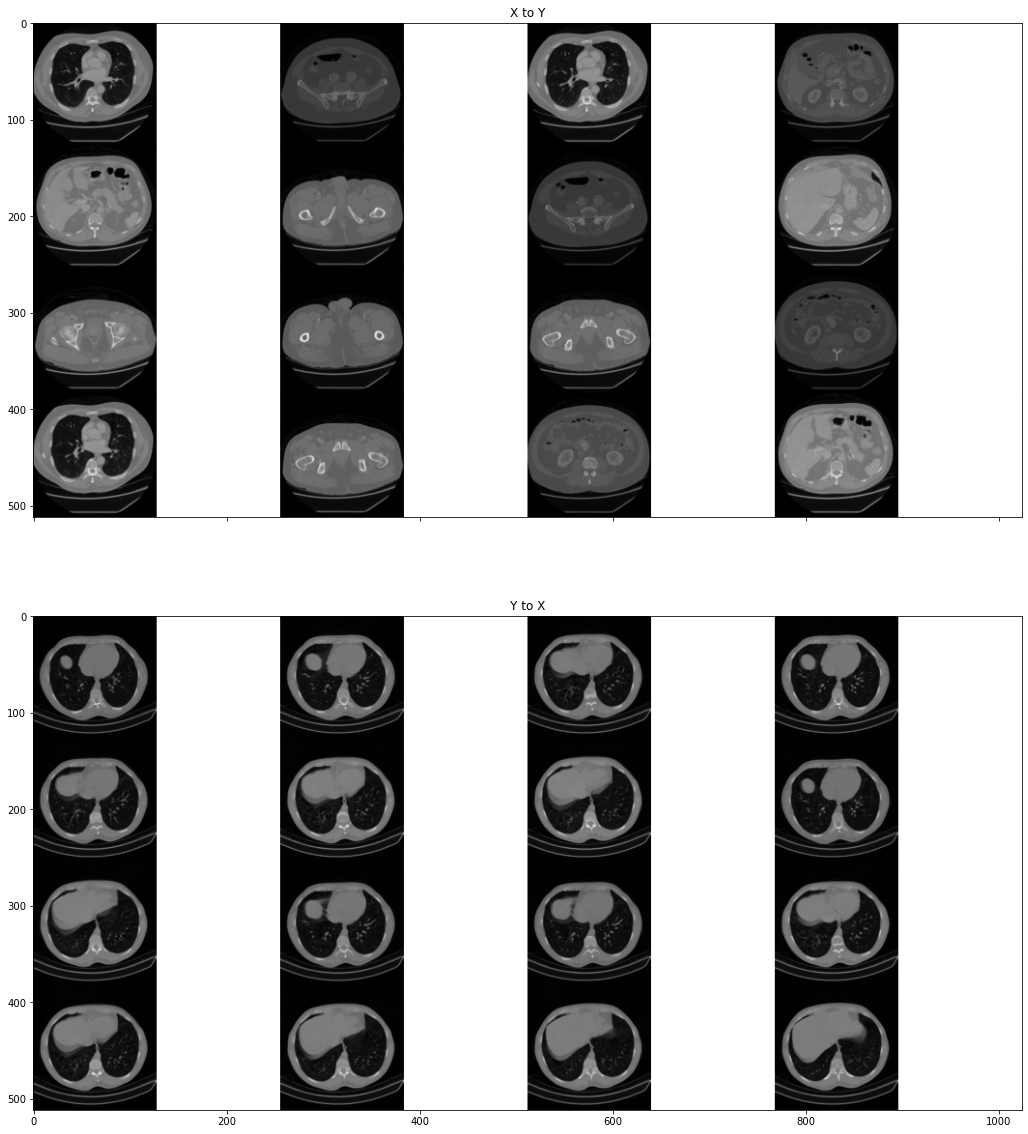

In [25]:
# Ver ejemplos de la iteración 100
view_samples(100, 'samples_cyclegan')

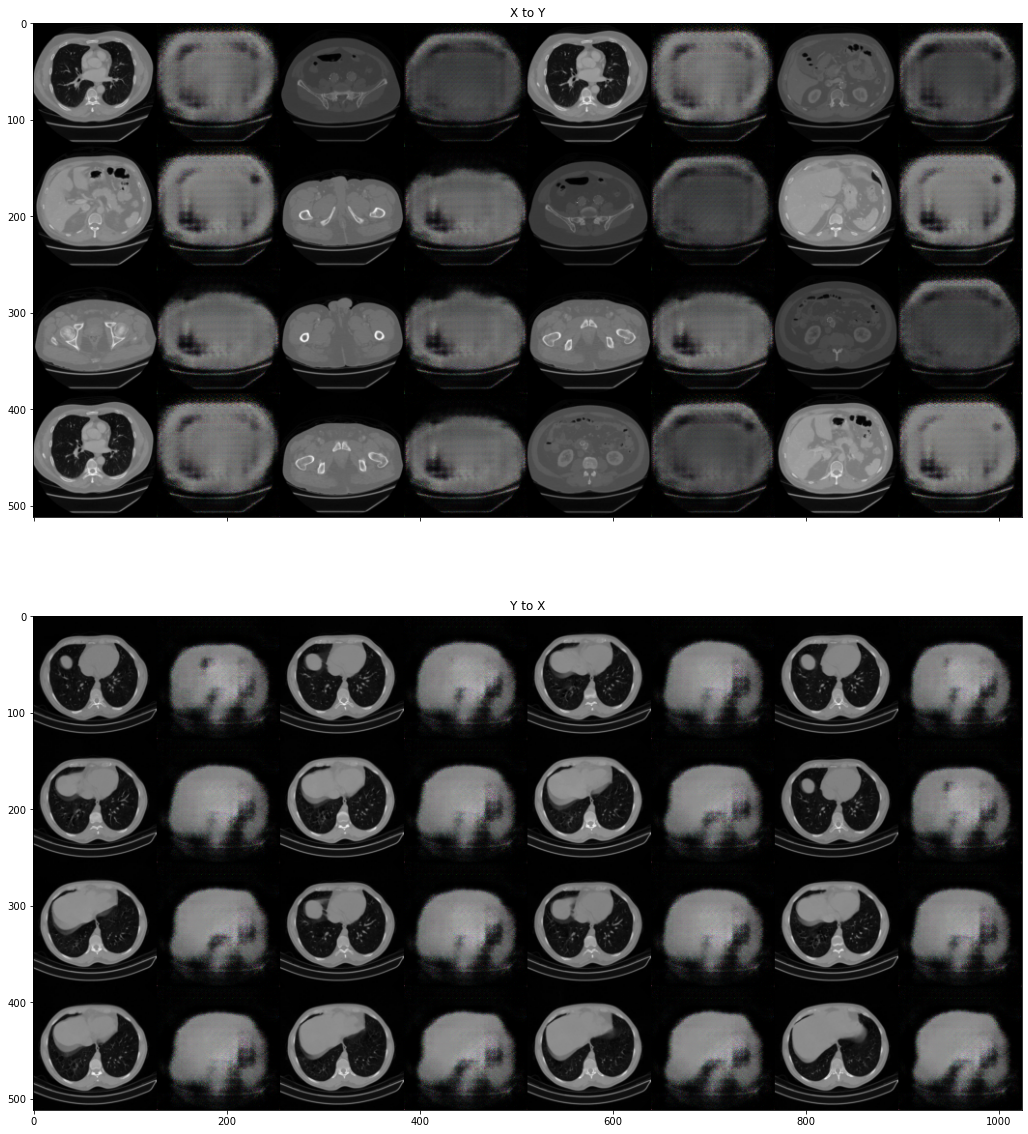

In [26]:
# Ver ejemplos de la iteración 100
view_samples(4000, 'samples_cyclegan')